In [2]:
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
import datetime
import calendar

from pypfopt.expected_returns import ema_historical_return
from pypfopt.risk_models import CovarianceShrinkage
import cvxpy as cp

import plotly.express as px
import plotly.graph_objects as go

In [3]:
esg_scores = pd.read_csv('ESG scores.csv', low_memory=False)
esg_scores.drop('Unnamed: 0', axis = 1, inplace = True)

In [4]:
esg_scores.head()

,Date,Peer_group_root,Type_Listing,Region,Country,Ticker,total_esg_score,governance_score,social_score,environment_score
0,20170706,Food Retailers,Private,Europe,Netherlands,NaN,70.68,67.75,74.29,68.64
1,20170706,Diversified Financials,Public,Europe,United Kingdom,NaN,49.14,53.00,57.51,35.32
2,20170706,Banks,Private,Europe,France,NaN,42.17,39.98,54.59,31.67
3,20170706,Oil & Gas Producers,Private,Latin America and Caribbean,Colombia,NaN,67.14,72.40,66.46,64.17
4,20170801,Food Retailers,Private,Europe,Netherlands,NaN,70.68,67.75,74.29,68.64


In [5]:
def filter_by_country_and_year(df, country, year):

    df = df[df['Country'] == country].copy()
    df.drop(['Country', 'Region'], axis=1, inplace=True)
    df = df[df['Type_Listing'] == 'Public']
    df = df.dropna()
    df.reset_index(drop=True, inplace=True)
    df.drop('Type_Listing', axis=1, inplace=True)

    def to_num(x):
        try:
            num_x = float(x)
            return num_x
        except:
            return np.nan

    df['total_esg_score'] = df['total_esg_score'].map(to_num)
    df['governance_score'] = df['governance_score'].map(to_num)
    df['social_score'] = df['social_score'].map(to_num)
    df['environment_score'] = df['environment_score'].map(to_num)

    df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
    df = df.loc[~df.duplicated(subset=['Date', 'Ticker'])]

    df_tot = df.pivot(index='Date', columns='Ticker', values='total_esg_score')
    df_e = df.pivot(index='Date', columns='Ticker', values='environment_score')
    df_s = df.pivot(index='Date', columns='Ticker', values='social_score')
    df_g = df.pivot(index='Date', columns='Ticker', values='governance_score')

    df_tot = df_tot.loc[year]
    df_e = df_e.loc[year]
    df_s = df_s.loc[year]
    df_g = df_g.loc[year]

    df_tot.dropna(axis=1, inplace=True)
    df_e.dropna(axis=1, inplace=True)
    df_s.dropna(axis=1, inplace=True)
    df_g.dropna(axis=1, inplace=True)

    return df_tot, df_e, df_s, df_g

In [6]:
esg_tot, esg_e, esg_s, esg_g = filter_by_country_and_year(esg_scores, 'United States', '2017')

In [7]:
esg_tot

Ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACM,ADBE,ADI,...,XYL,Y,YELP,YUM,ZBH,ZBRA,ZG,ZION,ZNGA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-11,68.98,53.85,47.04,67.28,63.00,51.05,61.32,58.98,73.25,72.04,...,72.17,47.36,45.71,53.97,55.72,52.41,44.97,49.01,41.03,50.91
2017-02-02,66.25,50.77,47.04,67.28,63.00,51.39,67.74,58.98,73.25,72.04,...,72.01,47.36,45.71,53.97,55.83,52.41,44.97,49.01,41.03,50.90
2017-03-08,66.25,50.77,47.04,67.28,66.13,51.39,67.74,58.98,73.25,72.04,...,72.01,47.36,45.71,53.97,55.83,52.41,44.97,49.01,41.03,50.90
2017-04-03,66.25,50.77,47.04,67.28,66.09,51.39,67.74,58.98,73.25,72.04,...,71.82,47.36,45.69,53.97,55.83,52.41,44.97,49.01,41.03,50.90
2017-05-04,66.39,51.02,47.04,67.28,66.23,52.64,67.86,58.98,73.50,72.04,...,72.11,47.36,45.69,53.47,56.95,52.41,44.97,49.01,41.03,50.90
2017-06-07,66.39,51.02,47.04,67.19,66.23,52.64,67.06,58.98,73.50,72.04,...,72.11,47.36,45.69,53.47,56.95,52.41,44.97,49.01,41.03,50.90
2017-07-06,66.39,51.02,47.04,67.19,66.23,52.64,67.06,58.98,67.68,72.04,...,72.11,47.36,45.69,53.47,56.95,52.41,44.95,49.01,41.03,50.90
2017-08-01,66.39,51.02,47.04,67.19,66.23,52.64,67.06,58.98,67.68,72.04,...,72.11,47.36,45.69,53.97,56.95,52.41,44.95,49.01,41.03,50.86
2017-09-08,66.39,51.02,47.04,67.19,66.23,52.64,67.06,58.24,67.68,72.04,...,72.11,47.36,46.22,53.97,56.95,52.41,44.95,49.01,46.55,50.86


<AxesSubplot:ylabel='Frequency'>

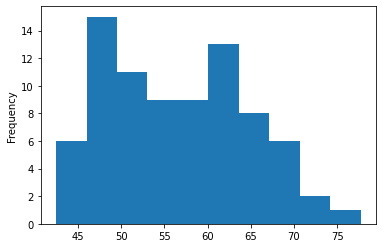

In [8]:
esg_sample = esg_tot.mean().sample(n=80, random_state=7).copy()
esg_sample.plot(kind='hist')

In [9]:
tickers = esg_sample.index.to_list()
esg_tot_sample = esg_tot[tickers].copy()
esg_e_sample = esg_e[tickers].copy()
esg_s_sample = esg_s[tickers].copy()
esg_g_sample = esg_g[tickers].copy()

In [10]:
year_start = esg_tot.index[0].date().year
month_start = esg_tot.index[0].date().month

year_end = esg_tot.index[-1].date().year
month_end = esg_tot.index[-1].date().month
last_day_date = calendar.monthrange(year_end, month_end)[1]

start = datetime.date(year_start,month_start,1)
end = datetime.date(year_end,month_end,last_day_date)

data_source = 'yahoo'

def get_stocks(ticker, source, start, end):
    stocks_list = []
    for tick in ticker:
        try:
            stocks = DataReader(tick, data_source, start, end)
            stocks_list.append(stocks[['Close']].add_suffix('_'+tick))
        except:
            continue
    
    all_stocks = pd.concat(stocks_list, axis = 1)
    return all_stocks

# Get Data and clean tickers
stocks = get_stocks(tickers, data_source, start, end)
clean_ticks = list(map(lambda x: x.split('_')[1], stocks.columns))
stocks.columns = clean_ticks

In [11]:
stocks.head()

,ASH,RHI,NFG,MAA,UPS,BWA,CMP,HUN,HSY,THO,...,DTE,THC,ZG,ARMK,DOV,PCAR,V,MA,TDS,DXCM
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,53.385517,49.759998,56.639999,97.320000,115.080002,40.070000,78.800003,19.260000,103.919998,100.480003,...,83.582977,15.40,37.380001,34.660000,61.728596,65.320000,79.500000,105.389999,30.400000,58.250000
2017-01-04,54.290607,50.910000,57.450001,98.209999,115.110001,40.820000,79.750000,19.709999,104.120003,103.570000,...,83.804253,16.75,37.299999,34.959999,62.019386,66.220001,80.150002,106.389999,31.129999,60.720001
2017-01-05,54.520550,48.599998,57.180000,98.080002,115.169998,40.770000,79.550003,19.500000,103.449997,101.690002,...,83.914894,16.60,36.810001,35.240002,61.817448,65.139999,81.089996,106.989998,30.889999,62.660000
2017-01-06,54.686890,48.299999,56.980000,98.000000,115.400002,41.099998,78.599998,19.209999,104.510002,102.169998,...,84.136169,16.40,37.139999,34.919998,62.778675,65.879997,82.209999,107.760002,30.770000,63.230000
2017-01-09,54.227005,48.349998,55.930000,97.400002,114.769997,40.820000,77.900002,19.280001,103.889999,101.059998,...,83.302132,17.25,37.220001,34.700001,61.970921,65.070000,81.750000,107.550003,30.240000,62.490002


In [12]:
esg_tot_sample = esg_tot_sample[clean_ticks]
esg_e_sample = esg_e_sample[clean_ticks]
esg_s_sample = esg_s_sample[clean_ticks]
esg_g_sample = esg_g_sample[clean_ticks]

In [13]:
class efficient_frontier():
    def __init__(self, stocks, up_bound, samples, ticks):
        self.stocks = stocks
        self.upper_bound = up_bound
        self.samples = samples
        self.ticks = ticks
    
    def optimize_portfolios(self):
        mu = ema_historical_return(self.stocks)
        s = CovarianceShrinkage(self.stocks).ledoit_wolf()
        n = len(mu)
        upper_bound = self.upper_bound
        w = cp.Variable(n)
        gamma = cp.Parameter(nonneg=True)
        ret = mu.to_numpy().T@w 
        risk = cp.quad_form(w, s.to_numpy())
        prob = cp.Problem(cp.Maximize(ret - gamma*risk), 
                          [cp.sum(w) == 1, w >= 0, w <= upper_bound])
        
        risk_data = np.zeros(self.samples)
        ret_data = np.zeros(self.samples)
        weights_data = []
        gamma_vals = np.logspace(-2, 3, num=self.samples)

        for i in range(self.samples):
            gamma.value = gamma_vals[i]
            prob.solve()
            weights = w
            weights_tick = pd.Series(weights.value, index=self.ticks)
            weights_tick_filter = weights_tick[weights_tick > 1.0e-03]
            weights_data.append(weights_tick_filter)
            risk_data[i] = cp.sqrt(risk).value
            ret_data[i] = ret.value
            
        weights_df = pd.concat(weights_data, axis = 1).T.fillna(0)
        rr_df = pd.DataFrame({'Return': ret_data, 'Risk': risk_data})
        self.portfolios_df = pd.concat([rr_df, weights_df], axis = 1)

In [14]:
conv_frontier = efficient_frontier(stocks, 0.05, 200, clean_ticks)
conv_frontier.optimize_portfolios()

In [15]:
# px.scatter(conv_frontier.portfolios_df, x='Risk', y='Return')

In [16]:
def screen(esg_df, stocks_df):
    mean_esg = esg_df.mean()
    thresh = mean_esg.quantile(0.3)
    mean_esg = mean_esg[mean_esg > thresh]
    screen_stocks = stocks_df[mean_esg.index]
    screen_ticks = screen_stocks.columns
    return screen_stocks, screen_ticks

In [17]:
# E Screen
e_stocks, e_ticks = screen(esg_e_sample, stocks)
e_frontier = efficient_frontier(e_stocks, 0.05, 200, e_ticks)
e_frontier.optimize_portfolios()

In [18]:
# px.scatter(e_frontier.portfolios_df, x='Risk', y='Return')

In [19]:
# S Screen
s_stocks, s_ticks = screen(esg_s_sample, stocks)
s_frontier = efficient_frontier(s_stocks, 0.05, 200, s_ticks)
s_frontier.optimize_portfolios()

In [20]:
# G Screen
g_stocks, g_ticks = screen(esg_g_sample, stocks)
g_frontier = efficient_frontier(g_stocks, 0.05, 200, g_ticks)
g_frontier.optimize_portfolios()

In [21]:
# ESG Screen
esg_stocks, esg_ticks = screen(esg_tot_sample, stocks)
esg_frontier = efficient_frontier(esg_stocks, 0.05, 200, esg_ticks)
esg_frontier.optimize_portfolios()

In [22]:
rr_conv = conv_frontier.portfolios_df[['Return', 'Risk']].copy()
rr_conv['Screen'] = 'No Screen'

rr_e = e_frontier.portfolios_df[['Return', 'Risk']].copy()
rr_e['Screen'] = 'E'

rr_s = s_frontier.portfolios_df[['Return', 'Risk']].copy()
rr_s['Screen'] = 'S'

rr_g = g_frontier.portfolios_df[['Return', 'Risk']].copy()
rr_g['Screen'] = 'G'

rr_esg = esg_frontier.portfolios_df[['Return', 'Risk']].copy()
rr_esg['Screen'] = 'ESG'

rr_all = pd.concat([rr_conv, rr_e, rr_s, rr_g, rr_esg])

In [23]:
px.scatter(rr_all, x='Risk', y='Return', color='Screen', width=1000, height=700)

In [24]:
px.line(rr_all, x='Risk', y='Return', color='Screen', width=1000, height=700)

In [25]:
def get_sharpe_rr_and_weights(df):
    df['Sharpe'] = (df['Return'] - 0.02) / df['Risk']
    sharpe_rr = df.iloc[df['Sharpe'].idxmax()].loc[['Return', 'Risk']]
    sharpe_weights = df.drop(['Return', 'Risk', 'Sharpe'], axis = 1).iloc[df['Sharpe'].idxmax()]
    sharpe_weights = sharpe_weights[sharpe_weights!=0]
    return sharpe_rr, sharpe_weights

In [26]:
conv_sh_rr, conv_sh_w = get_sharpe_rr_and_weights(conv_frontier.portfolios_df)
e_sh_rr, e_sh_w = get_sharpe_rr_and_weights(e_frontier.portfolios_df)
s_sh_rr, s_sh_w = get_sharpe_rr_and_weights(s_frontier.portfolios_df)
g_sh_rr, g_sh_w = get_sharpe_rr_and_weights(g_frontier.portfolios_df)
esg_sh_rr, esg_sh_w = get_sharpe_rr_and_weights(esg_frontier.portfolios_df)

In [27]:
sh_rr_all = pd.concat([conv_sh_rr, e_sh_rr, s_sh_rr, g_sh_rr, esg_sh_rr], axis=1).T
sh_rr_all['Screen'] = ['No Screen', 'E', 'G', 'S', 'ESG']
sh_rr_all

,Return,Risk,Screen
141,0.413723,0.074720,No Screen
139,0.375563,0.076072,E
138,0.365967,0.077365,G
138,0.347056,0.074929,S
137,0.374592,0.079311,ESG


In [28]:
fig = px.line(rr_all, x='Risk', y='Return', color='Screen')
fig.add_trace(
    go.Scatter(
        x=sh_rr_all['Risk'],
        y=sh_rr_all['Return'],
        mode='markers',
        marker=dict(
            color='LightSkyBlue',
            size=8,
            line=dict(
                color='MediumPurple',
                width=2
            )
        ),
        marker_symbol='cross-dot',
        showlegend=False,
    )
)
fig.update_layout(
    width=1000,
    height=700,
)
fig.show()

In [29]:
def compute_sh_portfolio(df, ticks, weights):
    stock_rets = df[ticks].pct_change().dropna()
    weighted_stock_rets = stock_rets * weights
    port_rets = weighted_stock_rets.sum(axis=1)
    cum_port_rets = (port_rets + 1).cumprod()
    return cum_port_rets

In [30]:
conv_sh_port = compute_sh_portfolio(stocks, conv_sh_w.index, conv_sh_w.values)
# conv_sh_port.plot()

In [31]:
e_sh_port = compute_sh_portfolio(stocks, e_sh_w.index, e_sh_w.values)
# e_sh_port.plot()

In [32]:
g_sh_port = compute_sh_portfolio(stocks, g_sh_w.index, g_sh_w.values)
# g_sh_port.plot()

In [33]:
s_sh_port = compute_sh_portfolio(stocks, s_sh_w.index, s_sh_w.values)
# s_sh_port.plot()

In [34]:
esg_sh_port = compute_sh_portfolio(stocks, esg_sh_w.index, esg_sh_w.values)
# esg_sh_port.plot()

In [ ]:
pd.concat([conv_sh_port,e_sh_port, s_sh_port, g_sh_port, esg_sh_port], axis = 1)